# Training and Deploying a Model

## Installing our required dependencies

In [1]:
! pip install --quiet gradio
! pip install --quiet -Uqq fastai
! pip install --quiet duckduckgo_search

In [5]:
from fastai.vision.all import *
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from time import sleep
from pathlib import Path
from tqdm.auto import tqdm
import gradio as gr

/home/null/miniconda3/envs/continual_pretraining/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Making our dataset

In [ ]:
categories = ["dog", "cat"] # Enter categories for images
max_images = 20 # Change this to a maximum amount images you choose

: 

In [6]:
output_folder = Path("data")

output_folder.mkdir(exist_ok=True, parents=True)

In [7]:
for category in tqdm(categories, desc="Categories"):
    dest = output_folder/category
    dest.mkdir(exist_ok=True, parents=True)

    search_results = ddg_images(category, max_results=max_images)
    urls = [result["image"] for result in search_results]

    for url in tqdm(urls, desc=category.capitalize()):
        try:
            download_url(url, dest, show_progress=False)
        except:
            continue

    resize_images(dest, max_size=400, dest=dest)

Categories:   0%|          | 0/2 [00:00<?, ?it/s]/home/null/miniconda3/envs/continual_pretraining/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
Dog: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
/home/null/miniconda3/envs/continual_pretraining/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Categories: 100%|██████████| 2/2 [00:27<00:00, 13.55s/it]


In [8]:
failed = verify_images(get_image_files(output_folder))
failed.map(Path.unlink)
print("Failed to download images: ", len(failed))

Failed to download images:  0


In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=[Resize(128, method="squish")],
).dataloaders(output_folder, bs=8)

/home/null/miniconda3/envs/continual_pretraining/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


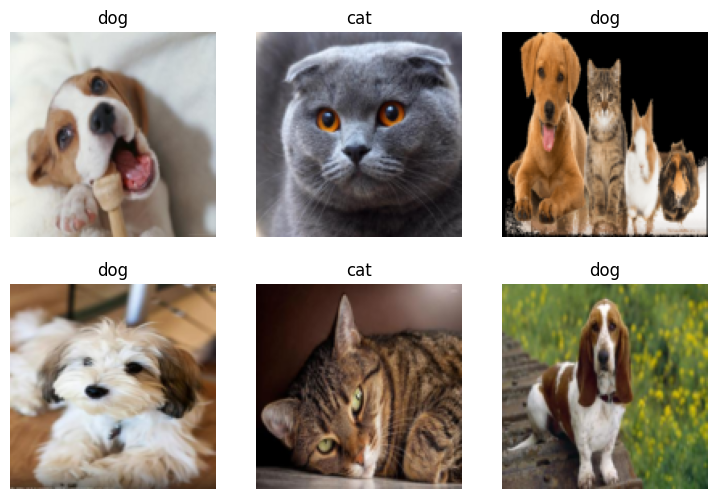

In [10]:
dls.show_batch(max_n=6)

## Training, Evaluating, and Saving our Model

In [11]:
import time 
learn = vision_learner(dls, resnet18, metrics=[error_rate])
time_start = time.time()
learn.fine_tune(4)
end_time = time.time()
print(f"Training time: {end_time - time_start}")

/home/null/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/null/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.209979,1.999071,0.571429,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.035719,0.560598,0.285714,00:01
1,0.630104,0.021082,0.000000,00:01
2,0.504072,0.004183,0.000000,00:01
3,0.374394,0.003908,0.000000,00:01


Training time: 7.808526277542114


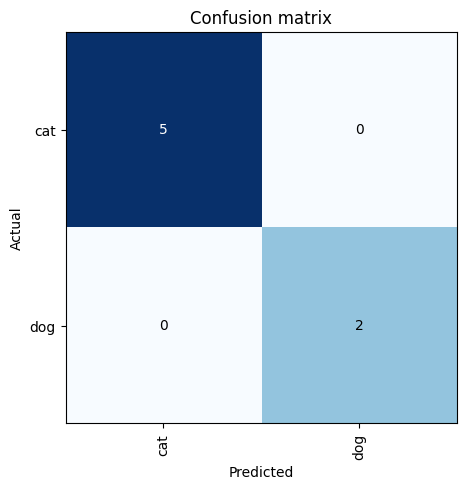

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

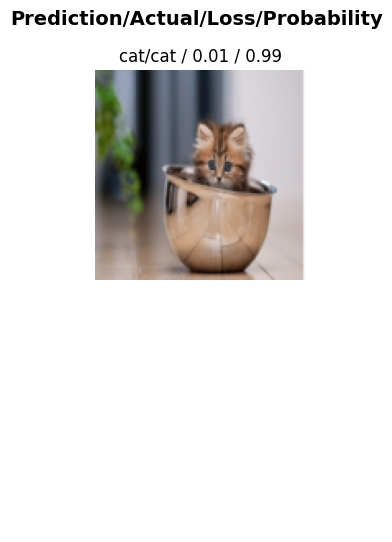

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(1, nrows=2)

In [14]:
learn.export('model.pkl')

## Deployment

In [15]:
class Classifier:
    def __init__(self, model_path):
        self.learn = load_learner(model_path)

    def predict(self, image):
        pred, pred_idx, probs = self.learn.predict(image)
        return {self.learn.dls.vocab[i]: float(p) for i, p in enumerate(probs)}

In [16]:
image = gr.inputs.Image(shape=(128, 128))
label = gr.outputs.Label()
classifer = Classifier(model_path="model.pkl")

interface = gr.Interface(fn=classifer.predict, inputs=image, outputs=label)
interface.launch(inline=False)

/tmp/ipykernel_5171/2047567709.py:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(128, 128))
/tmp/ipykernel_5171/2047567709.py:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(128, 128))
/tmp/ipykernel_5171/2047567709.py:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label()
/tmp/ipykernel_5171/2047567709.py:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
